<a href="https://www.kaggle.com/code/edaentrk/animal-detection-with-cnn?scriptVersionId=214319438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ANIMAL DETECTION WITH CNN
This project is a project prepared for Aygaz Image Processing Bootcamp organized by Aygaz and Global Ai Hub.

## Introduction
* The aim of this project is to strengthen the foundation of CNN models. For this, we will build a CNN model and classify various animal species with this model. For example, we will distinguish two classes such as "panda" and "dog" with CNN. We will understand what steps we need to take so that CNN models can also "simply" make this distinction that we can make with a single glance.

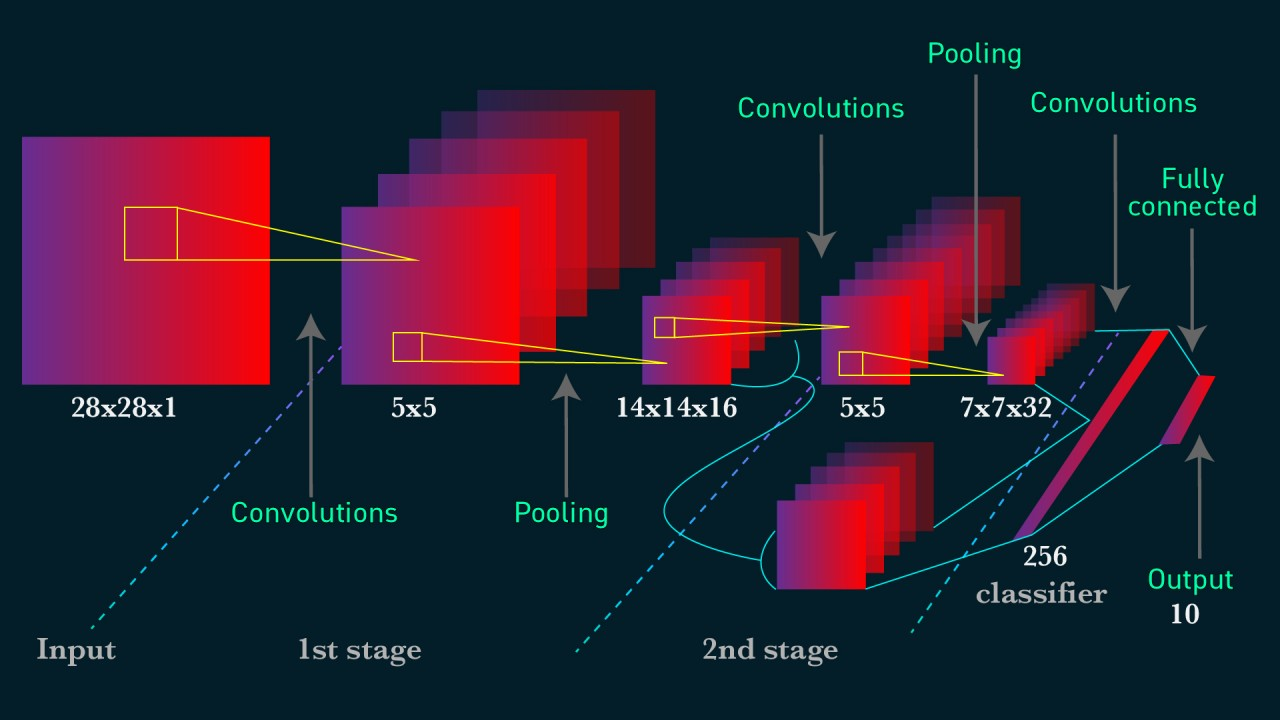

## Project Steps
1. [Python Libraries](#1) 
2. [Using the Dataset](#2) 
3. [Preparing the dataset](#3) 
4. [Designing the CNN Model ](#4) 
5. [Testing the model](#5) 
6. [Manipulating images with different lights](#6)
7. [Evaluation of the model with manipulated test set](#7) 
8. [Using color constancy algorithm on manipulated test set](#8)
9. [Testing the model with the color constancy applied test set](#9)
10. [Comparing and reporting the success of different test sets](#10)



<a id='1'></a>
## Python Libraries
* os:Used for file and directory operations, such as accessing folders or managing files.
* numpy:A powerful library for mathematical computations, arrays, and matrix operations.
* cv2:(OpenCV): Facilitates image processing tasks, including reading, editing, and manipulating images.
* PIL:  is commonly used in image processing tasks.
* pytorch:is a popular deep learning framework used for a variety of reasons, particularly in research and production settings.
* sklearn:is widely used because of its ease of use, variety of machine learning algorithms, powerful data preprocessing tools, model evaluation capabilities, and integration with other libraries
* matplotlib:A library for data visualization, enabling the creation of graphs, histograms, and other visual representations.
* pandas: is used because it provides a rich set of tools for data manipulation, cleaning, and analysis, with its powerful DataFrame structure being the backbone of most data-related tasks.


In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

<a id='2'></a>
## Using the Dataset
* This section defines the dataset and hyperparameter settings for deep learning model training. The dataset is taken from the specified directory on Kaggle and only images belonging to specific animal classes such as collie, dolphin, elephant will be used. All images are resized to 128x128 pixels to be compatible with the model and a maximum of 650 images are selected from each class. During training, the dataset will be divided into 35 batches and the model will be trained for a total of 20 epochs. For computations, cuda is used if a GPU is available; otherwise, it will work with the CPU. These settings ensure that the data is processed and the model training is compatible with the hardware.

In [2]:
# Dataset location and parameter determination
data_konum = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
istenen_siniflar = ['collie', 'dolphin', 'elephant', 'fox', 'moose', 'rabbit', 'sheep', 'squirrel', 'giant panda', 'polar bear']
boyut = (128, 128) 
sinif_resim_sayisi = 650
batch_sayisi = 35
epoch_sayisi = 20
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<a id='3'></a>
## Preparing the dataset
* This section covers the data preparation process for the deep learning model. First, a function is defined to load images and class labels. This function takes images belonging to target classes located in a specific file path, resizes them, and adds them to two separate lists with their class numbers. These lists are then converted to numpy arrays and returned as output.

* After the data loading process, the dataset is divided into training and test. This separation is done at 70% for training and 30% for testing. Training and test data are kept separate to evaluate the performance of the model.

* A series of transformation operations are defined to make the images suitable for the model. These operations include steps such as resizing the images, converting to grayscale, blurring, converting to tensor format, and normalizing. These transformations prepare the images in a format suitable for the model and at a scale.

* Finally, the dataset is organized for training and test data with PyTorch's Dataset and DataLoader structures. While Dataset is the basic unit of the dataset, DataLoader splits this data into small groups (mini-batches) so that the model can use the data more efficiently during training. While the training data is shuffled, the test data is loaded sequentially. This structure makes the data preparation process completely automatic and optimized for model training.

In [3]:
# Preparing Data
class AnimalDataset(Dataset):
    def __init__(self, resim, sinif, transform=None):
        self.images = resim
        self.labels = sinif
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        resim = self.images[idx]
        sinif = self.labels[idx]

        if self.transform:
            resim = self.transform(resim)

        return resim, sinif

In [4]:
# Data loading function
def veriyukle(data_konum, istenen_siniflar, boyut, sinif_resim_sayisi):
    resimler = []
    siniflar = []
    for sinif, baslik in enumerate(istenen_siniflar):
        data_konum = os.path.join(data_konum, baslik)
        if not os.path.exists(data_konum):
            continue

        dosyalar = os.listdir(data_konum)[:sinif_resim_sayisi]
        for dosya in dosyalar:
            resim_konum = os.path.join(data_konum, dosya)
            resim = cv2.imread(resim_konum)
            boyutlanmis_resim = cv2.resize(resim, boyut)    
            resimler.append(boyutlanmis_resim)
            siniflar.append(sinif)

    resimler = np.array(resimler, dtype=np.float32)
    siniflar = np.array(siniflar, dtype=np.int64)
    return resimler, siniflar

In [5]:
# Load the data
X, y = veriyukle(data_konum, istenen_siniflar, boyut, sinif_resim_sayisi)

In [6]:
# Sepearte the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 6)

In [7]:
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.Grayscale(3),
    transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = AnimalDataset(X_train, y_train, transform=transform)
test_dataset = AnimalDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_sayisi, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sayisi, shuffle=False)

<a id='4'></a>
## Designing the CNN Model
*This section involves building and preparing a Convolutional Neural Network (CNN) model for training.

# Model Structure
* CNNModel Class: Inherits from PyTorch's nn.Module and defines a CNN model with two main components:

  * features: Handles feature extraction.
    * The first convolutional layer takes 3 input channels (e.g., RGB channels of a color image) and outputs 32 channels.
    * Batch normalization and an activation function (ReLU) are applied.
    * Max pooling reduces the spatial dimensions.
    * Dropout is applied to prevent overfitting.
    * The second convolutional layer takes 32 input channels and outputs 64 channels, repeating the same operations.
  * classifier: Responsible for classification. It is initialized as None and dynamically created during the forward pass based on the input shape.
* _initialize_classifier Method: Defines the classification layer dynamically based on the flattened size of the output from the features layers. The classification layer includes a fully connected (Linear) layer that outputs the number of classes.

* forward Method: Defines the forward pass of the model.
 * Input data is passed through the features layers.
If the classifier is not yet initialized, it is created dynamically using the flattened size of the output from the features layers and moved to the appropriate device (CPU or GPU).
 * The data is then passed through the classifier to produce the final outputs.
* Model Preparation for Training
  * Model Initialization: An instance of the model is created, with the number of classes set to the number of target classes.
  * Device Selection: The model is moved to GPU if available; otherwise, it remains on the CPU.
  * Loss Function: CrossEntropyLoss is used, which is suitable for multi-class classification problems.
  * Optimization Algorithm: The Adam optimizer is chosen to update the model's weights, with a learning rate of 0.001.

In [8]:
# CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5)
        )
        self.classifier = None
        self.num_classes = num_classes

    def _initialize_classifier(self, input_shape):
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        if self.classifier is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self._initialize_classifier(flattened_size)
            self.classifier.to(x.device)
        x = self.classifier(x)
        return x

# Initialize the model, loss function and optimizer
net = CNNModel(len(istenen_siniflar))
net.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

<a id='5'></a>
## Testing the Model
* This section focuses on training and evaluating the CNN model through iterative loops. The train_model function handles the training process for one epoch, setting the model to training mode and iterating over the training data in batches. For each batch, the inputs and labels are transferred to the selected device (GPU or CPU), the optimizer resets gradients, predictions are made, and the loss is calculated and backpropagated. The optimizer then updates the model’s parameters, and the loss is accumulated to compute the average loss for the epoch. The evaluate_model function assesses the model's performance on the test data by switching the model to evaluation mode, iterating over the test dataset without tracking gradients, and calculating the number of correct predictions for accuracy. In the main loop, this training and evaluation process is repeated for a specified number of epochs. After each epoch, the average training loss and test accuracy are logged and stored for performance tracking. The loop concludes with a message indicating the end of training, ensuring the model is iteratively optimized and evaluated for its ability to generalize.

In [9]:
# Training and Testing Loops
def train_model(model, train_loader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate_model(model, test_loader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

accuracy_list = []
for epoch in range(epoch_sayisi):
    train_loss = train_model(net, train_loader, criterion, optimizer, dev)
    accuracy = evaluate_model(net, test_loader, dev)
    accuracy_list.append(accuracy)
    print(f"Epoch {epoch + 1}/{epoch_sayisi}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Eğitim bitti!")



Epoch 1/20, Loss: 2.3433, Accuracy: 1.54%
Epoch 2/20, Loss: 1.8214, Accuracy: 1.03%
Epoch 3/20, Loss: 1.5991, Accuracy: 1.54%
Epoch 4/20, Loss: 1.4648, Accuracy: 4.10%
Epoch 5/20, Loss: 1.4052, Accuracy: 11.28%
Epoch 6/20, Loss: 1.2674, Accuracy: 25.64%
Epoch 7/20, Loss: 1.1658, Accuracy: 34.87%
Epoch 8/20, Loss: 1.1453, Accuracy: 37.95%
Epoch 9/20, Loss: 1.0525, Accuracy: 46.67%
Epoch 10/20, Loss: 0.9798, Accuracy: 54.36%
Epoch 11/20, Loss: 0.9471, Accuracy: 68.21%
Epoch 12/20, Loss: 0.8660, Accuracy: 66.67%
Epoch 13/20, Loss: 0.8730, Accuracy: 57.95%
Epoch 14/20, Loss: 0.8284, Accuracy: 69.74%
Epoch 15/20, Loss: 0.7469, Accuracy: 72.82%
Epoch 16/20, Loss: 0.7364, Accuracy: 74.87%
Epoch 17/20, Loss: 0.6707, Accuracy: 76.92%
Epoch 18/20, Loss: 0.6665, Accuracy: 75.90%
Epoch 19/20, Loss: 0.6480, Accuracy: 84.62%
Epoch 20/20, Loss: 0.6283, Accuracy: 86.67%
Eğitim bitti!


<a id='6'></a>
## Manipulating images with different lights
 * Input: The function takes a list of images (images).
 * Process: For each image in the list, the function performs an intensity adjustment
 * using cv2.convertScaleAbs:
    * alpha=1.5: This is a scaling factor that multiplies the pixel values. It enhances the image's contrast by making the differences between pixel values more pronounced.
    * beta=25: This is an offset that adds a constant value to all pixel values. It brightens the image by increasing the intensity of all pixels.
    * These operations are applied to each image to adjust its brightness and contrast.
 * Output: The function returns a NumPy array of the manipulated images (manipulated_images), with the pixel values cast to np.float32 for consistency in image processing tasks.


In [10]:
## Manipulate Methods.
def get_manipulated_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=25)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images, dtype= np.float32)

<a id='7'></a>
## Evaluation of the model with manipulated test set
* This section manipulates the test set and evaluates the model's performance on the altered images. First, the get_manipulated_images function is used to adjust the brightness and contrast of the test set (X_test), resulting in the manipulated_test_images. Then, a new dataset (manipulated_test_dataset) is created using the manipulated images and their corresponding labels (y_test), with the same transformation (transform) applied. This dataset is loaded into a DataLoader (manipulated_test_loader) for efficient batching and processing. The model's performance is then evaluated on this manipulated test set using the evaluate_model function, and the accuracy (manipulated_accuracy) is calculated. Finally, the accuracy of the model on the manipulated test set is printed, showing how the model performs after the images have been altered.

In [11]:

# Manipulate the test set
manipulated_test_images = get_manipulated_images(X_test)

# create a new maniplated dataset and dataloader
manipulated_test_dataset = AnimalDataset(manipulated_test_images, y_test, transform=transform)
manipulated_test_loader = DataLoader(manipulated_test_dataset, batch_size=batch_sayisi, shuffle=False)

# calculate the accuracy for manipulated test set
manipulated_accuracy = evaluate_model(net, manipulated_test_loader, dev)
print(f"Manipüle edilmiş test setindeki doğruluk: {manipulated_accuracy:.2f}%")


Manipüle edilmiş test setindeki doğruluk: 34.87%


<a id='8'></a>
## Using color constancy algorithm on manipulated test set
This section of code applies the Gray World algorithm to correct the color balance of the manipulated test set, then plots the model’s accuracy over the training epochs.


* Applying Gray World Correction:

    * The function apply_gray_world(image) implements the Gray World algorithm for color correction. The algorithm works by adjusting the color balance of an image so that the average color (brightness) of the image is balanced across the red, green, and blue channels.
    * Step 1: cv2.mean(image)[:3] calculates the average intensity of the blue, green, and red channels in the image.
    * Step 2: The average intensity values of the blue, green, and red channels are used to compute a "gray value," which is the target average intensity for all channels.
    * Step 3: Scaling factors are calculated for each color channel by dividing the target gray value by the average intensity of that channel.
    * Step 4: The image is then adjusted by multiplying each pixel's value by the corresponding scaling factor. This step adjusts the image to match the desired average color balance.
    * Step 5: np.clip() ensures that pixel values stay within the valid range of [0, 255], and the image is converted back to an unsigned 8-bit integer format (np.uint8).
The apply_gray_world function is applied to each manipulated image in the manipulated_test_images list, resulting in the color-corrected images stored in X_test_corrected.


In [12]:
def apply_gray_world(image):
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    gray_value = (avg_b + avg_g + avg_r) / 3
    scaling_factors = np.array([gray_value / avg_b, gray_value / avg_g, gray_value / avg_r])
    corrected_image = image * scaling_factors
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image

X_test_corrected = np.array([apply_gray_world(img) for img in manipulated_test_images])
# Yeni bir dataset ve dataloader oluştur
manipulated_test_dataset = AnimalDataset(X_test_corrected, y_test, transform=transform)
manipulated_test_loader = DataLoader(manipulated_test_dataset, batch_size=batch_sayisi, shuffle=False)

# Manipüle edilmiş test setinde doğruluğu hesapla
corrected_accuracy = evaluate_model(net, manipulated_test_loader, dev)
print(f"Manipüle edilmiş test setindeki doğruluk: {corrected_accuracy:.2f}%")

Manipüle edilmiş test setindeki doğruluk: 49.74%


<a id='9'></a>
## Testing the model with the color constancy applied test set
* Plotting Accuracy Over Epochs:

    * The x list contains the epoch numbers (from 1 to 20), and the y list contains the accuracy values from the accuracy_list.
    * plt.plot(x, y) creates a plot showing how the accuracy changes with each epoch during training.
    * plt.xlabel("Epoch") and plt.ylabel("Accuracy") label the x-axis and y-axis of the plot, respectively.
    * plt.show() displays the plot, allowing us to visualize the model’s performance improvement over time.

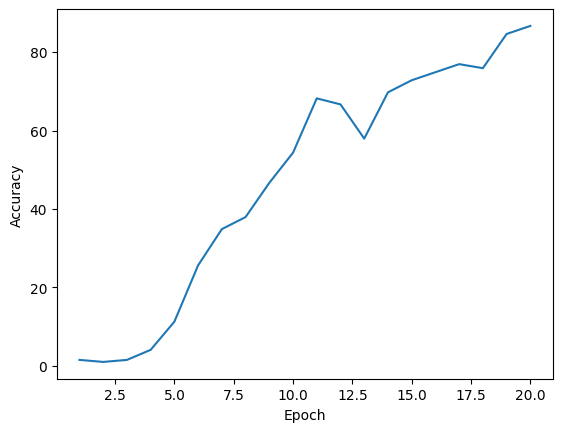

In [13]:
x = [*range(1,21,1)]
y = accuracy_list

plt.plot(x, y)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

<a id='10'></a>
## Comparing and reporting the success of different test sets

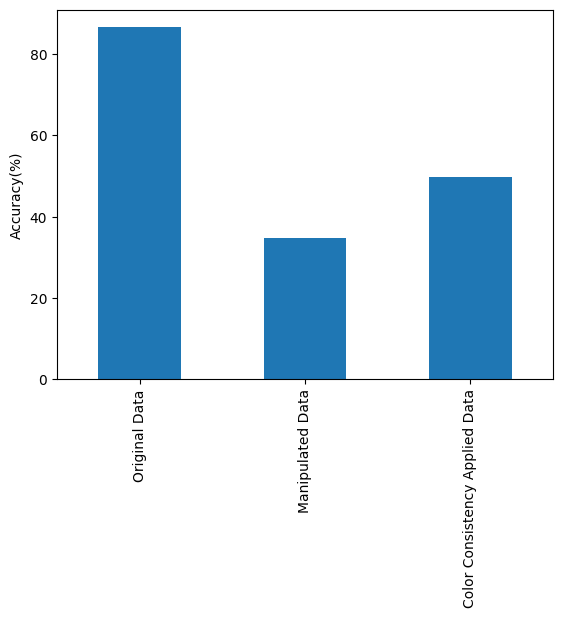

In [14]:
data = {'Original Data': accuracy, 'Manipulated Data': manipulated_accuracy, 'Color Consistency Applied Data': corrected_accuracy}
series = pd.Series(data)
series.plot(kind='bar')
plt.ylabel("Accuracy(%)")
plt.show()